In [78]:
import numpy as np
import matplotlib.pyplot as plt
#from utils import *
import copy
%matplotlib inline
import pandas as pd
import seaborn as sns
import sklearn.model_selection, sklearn.preprocessing


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB
None
       Hours Studied  Previous Scores   Sleep Hours  \
count   10000.000000     10000.000000  10000.000000   
mean        4.992900        69.445700      6.530600   
std         2.589309        17.343152      1.695863   
min         1.000000        40.000000      4.000000   
25%         3.000000        54.000000      5.

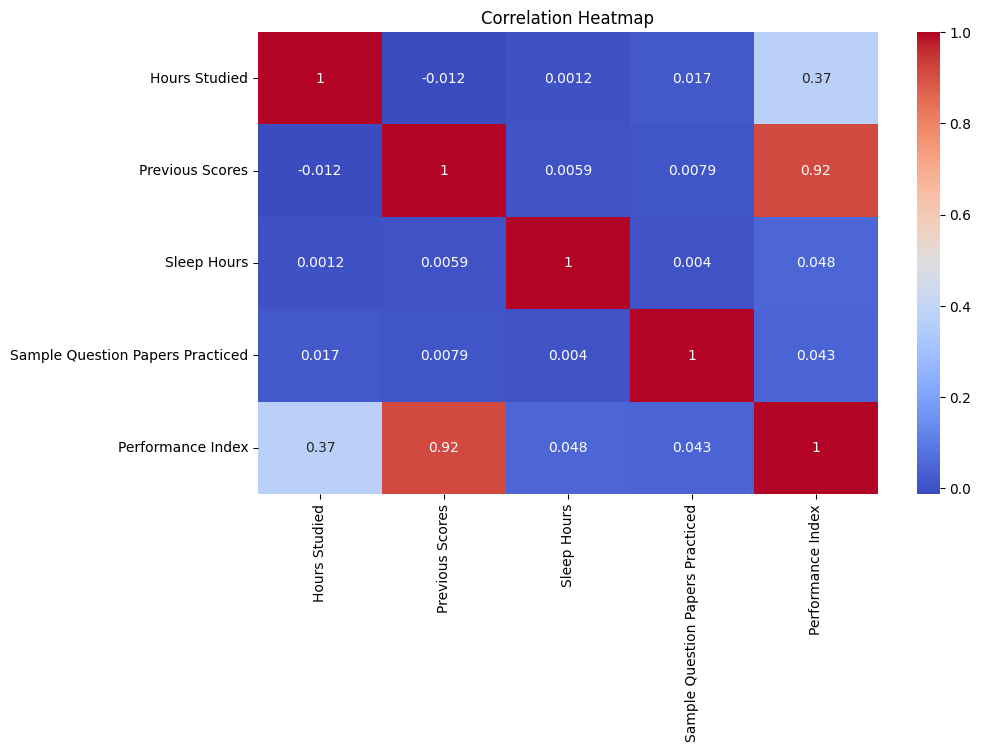

In [79]:
df = pd.read_csv('Student_Performance.csv')

print(df.info())
print(df.describe())
print(df.isnull().sum())

numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()



1  або близько 1 → сильна позитивна кореляція (збільшення предиктора → збільшення Performance Index)
1 або близько -1 → сильна негативна кореляція (збільшення предиктора → зменшення Performance Index)
0 → майже відсутня лінійна залежність

Обробка категоріальних змінних:

Тепер Extracurricular Activities можна використовувати разом з іншими чисельними колонками: Всі унікальні значення будуть перетворені у числа від 0 до N-1

In [80]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Extracurricular Activities'] = le.fit_transform(df['Extracurricular Activities'])

Вибір ознак та цільової змінної: Цільова змінна (target) — Performance Index.

In [81]:
y = df ['Performance Index']

# Ознаки — всі інші стовпці, крім 'Performance Index'
# Якщо хочеш виключити колонки, які прямо впливають на Performance Index (наприклад, агреговані показники), можеш їх видалити
X = df.drop('Performance Index', axis=1)

# Перевіримо перші рядки
X.head(10)
y.head(10)

0    91.0
1    65.0
2    45.0
3    36.0
4    66.0
5    61.0
6    63.0
7    42.0
8    61.0
9    69.0
Name: Performance Index, dtype: float64

In [82]:

#Поділ на навчальну вибірку та тестову вибірку
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)


In [83]:
from sklearn.preprocessing import StandardScaler

numeric_cols = ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']

# Ініціалізація скалера
scaler = StandardScaler()

# Навчання скалера на X_train
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

# Трансформація X_test за тим самим скалером
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

#Додаємо стовпчик одиниць для intercept
X_train_final = np.hstack([np.ones((X_train.shape[0], 1)), X_train.values])
X_test_final  = np.hstack([np.ones((X_test.shape[0], 1)), X_test.values])

print("X_train shape:", X_train_final.shape)
print("X_test shape:", X_test_final.shape)

X_train shape: (5000, 6)
X_test shape: (5000, 6)


np.ones((X_train.shape[0], 1)) → створює стовпчик одиниць розміром кількість рядків × 1.

np.hstack([...]) → горизонтально об’єднує стовпчик одиниць з нормалізованими ознаками.

Після цього матриця X_train_scaled має перший стовпець з одиниць, який відповідає β₀ (intercept) при множенні на вектор коефіцієнтів β.

РЕАЛІЗАЦІЯ МЕТОДУ ГРАДІЄНТНОГО СПУСКУ

In [84]:
b = np.zeros(X_train_final.shape[1])
learning_rate = 0.01   #швидкість навчання
epochs = 1000          #к-сть ітерацій

#Функція для обчислення функції втрат
def compute_cost(X, y, b):
    predictions = X.dot(b)
    errors = predictions - y
    mse = (1 / len(y)) * np.sum(errors ** 2)
    return mse

#print (compute_cost(X, y, b))


In [85]:
#Функція градієнтного спуску:

def gradient_descent(X, y, b, learning_rate, epochs):
    cost_history = [] # Для відстеження змін MSE
    m = len(y)  #m — кількість рядків (спостережень) у тренувальній вибірці.
    for _ in range(epochs):
    # Обчислення передбачень
        y_pred = X.dot(b)
    # Обчислення помилки
        error = y_pred - y.values
    # Обчислення градієнта (похідна MSE за b)
        gradient = (2/m) * X.T.dot(error)
    # Оновлення ваг
        b = b - learning_rate * gradient
    # Збереження поточного MSE для історії
        cost = compute_cost(X, y, b)
        cost_history.append(cost)
    return b, cost_history



In [86]:
#Навчання моделі
b_final, cost_history = gradient_descent(X_train_final, y_train, b, learning_rate, epochs)

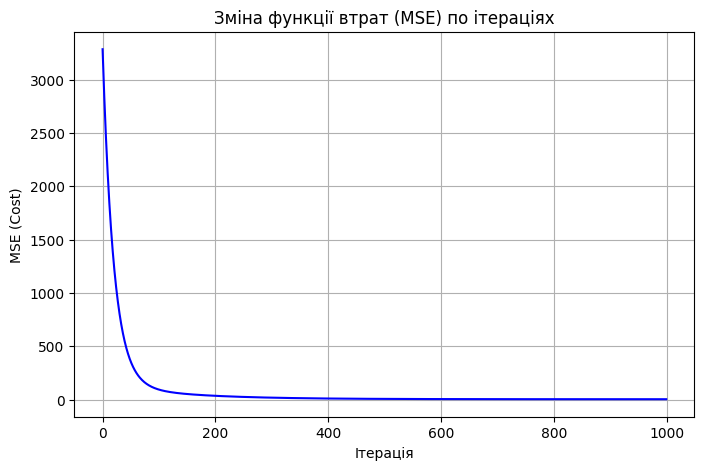

In [87]:
plt.figure(figsize=(8,5))
plt.plot(cost_history, color='blue')
plt.title("Зміна функції втрат (MSE) по ітераціях")
plt.xlabel("Ітерація")
plt.ylabel("MSE (Cost)")
plt.grid(True)
plt.show()

Оцінка якості моделі на тестових даних

In [88]:
#прогнозування
y_pred_test = X_test_final.dot(b_final)

#розрахунок метрик
mse_test = np.mean((y_test - y_pred_test) ** 2)
r2_test = 1 - np.sum((y_test - y_pred_test) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)


R-squared — це коефіцієнт детермінації, який показує, наскільки добре модель пояснює змінність цільової змінної.

In [89]:
y_mean = np.mean(y_train)

# Передбачення бейзлайну (той самий розмір, що у тестовій вибірці)
y_baseline_pred = np.full_like(y_test, fill_value=y_mean, dtype=float)

# Обчислення метрик для бейзлайну
mse_baseline = np.mean((y_test - y_baseline_pred)**2)
r2_baseline = 1 - np.sum((y_test - y_baseline_pred)**2) / np.sum((y_test - np.mean(y_test))**2)
print("Baseline MSE:", mse_baseline)
print("Baseline R²:", r2_baseline)

Baseline MSE: 371.275708
Baseline R²: -0.00087708815583043


Лінійність зв'язку

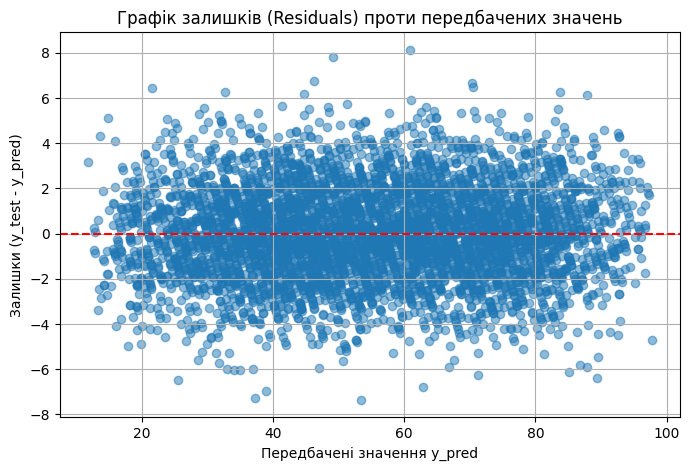

In [90]:
residuals = y_test - y_pred_test

plt.figure(figsize=(8,5))
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # горизонтальна лінія на нулі
plt.title("Графік залишків (Residuals) проти передбачених значень")
plt.xlabel("Передбачені значення y_pred")
plt.ylabel("Залишки (y_test - y_pred)")
plt.grid(True)
plt.show()

In [91]:
from sklearn.preprocessing import StandardScaler

numeric_cols = ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']

# Ініціалізація скалера
scaler = StandardScaler()

# Навчання скалера на X_train
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

# Трансформація X_test за тим самим скалером
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

#Додаємо стовпчик одиниць для intercept
X_train_final = np.hstack([np.ones((X_train.shape[0], 1)), X_train.values])
X_test_final  = np.hstack([np.ones((X_test.shape[0], 1)), X_test.values])

print("X_train shape:", X_train_final.shape)
print("X_test shape:", X_test_final.shape)

X_train shape: (5000, 6)
X_test shape: (5000, 6)


VIF

In [92]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# X_final — матриця ознак після масштабування і додавання стовпця одиниць (intercept)
X_vif = X_train.copy()  # без стовпця одиниць

# Створюємо DataFrame для VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns  
vif_data["VIF"] = [variance_inflation_factor(X_vif, i) for i in range(X_vif.shape[1])]

print(vif_data)

                            feature       VIF
0                     Hours Studied  1.000655
1                   Previous Scores  1.000470
2        Extracurricular Activities  1.000510
3                       Sleep Hours  1.000803
4  Sample Question Papers Practiced  1.000230


Нормальність залишків

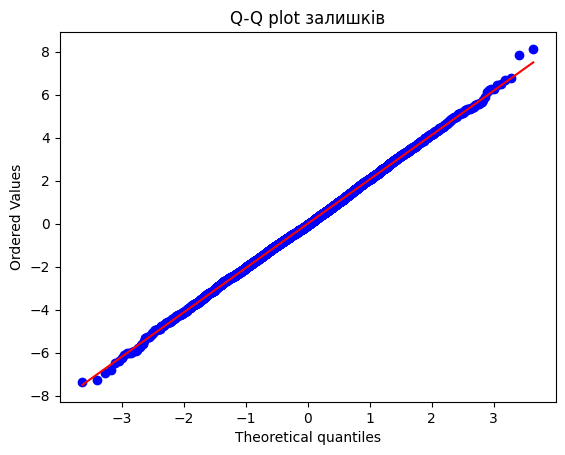

In [93]:
#q-q plot
import scipy
from scipy import  stats

scipy.stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q plot залишків")
plt.show()

In [94]:
from scipy.stats import shapiro

stat, p_value = shapiro(residuals)
print("Shapiro-Wilk test p-value:", p_value)
if p_value > 0.05:
    print("Залишки приблизно нормальні")
else:
    print("Залишки не нормальні")


Shapiro-Wilk test p-value: 0.47049506644450745
Залишки приблизно нормальні


Гомоскедастичність (постійна дисперсія залишків): Дисперсія залишків має бути
постійною.
* Метод: Той самий графік, що й для лінійності (залишки від прогнозів).
* Очікування: "Хмара" точок повинна мати приблизно однакову ширину по всій
довжині.
* Проблема: Якщо хмара нагадує "воронку" (дисперсія зростає/зменшується),
це гетероскедастичність.

Тест Дарбіна - Вотсона

In [95]:
from statsmodels.stats.stattools import durbin_watson

# Припустимо, що residuals = y_test - y_pred_test
dw_stat = durbin_watson(residuals)
print("Durbin-Watson statistic:", dw_stat)

# Інтерпретація
if 1.5 < dw_stat < 2.5:
    print("Автокореляції залишків немає або вона незначна")
else:
    print("Є ознаки автокореляції залишків")


Durbin-Watson statistic: 2.035427852041373
Автокореляції залишків немає або вона незначна


Викиди - Cook's distance


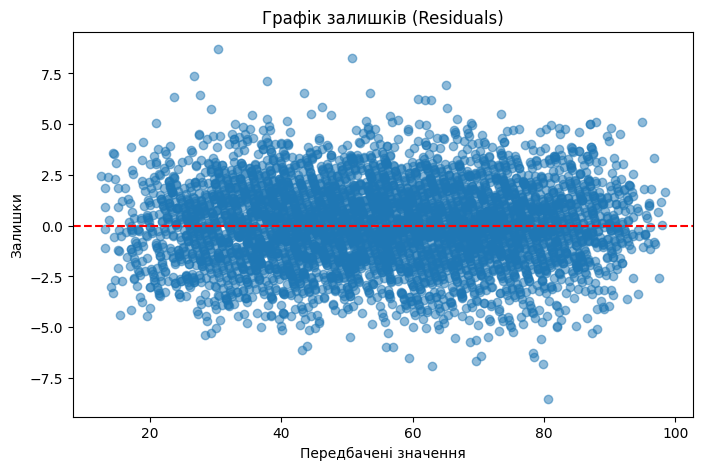

Кількість впливових спостережень: 241
Індекси впливових спостережень: [  26   49   55  136  168  172  189  245  247  260  271  272  296  313
  329  336  380  399  409  421  433  442  476  500  505  531  541  544
  564  598  602  609  633  643  662  674  703  759  772  776  785  799
  817  823  870  915  931  945  955  991 1025 1027 1047 1091 1093 1130
 1153 1206 1207 1221 1242 1258 1288 1344 1350 1360 1361 1364 1408 1412
 1415 1530 1574 1632 1670 1675 1680 1695 1701 1705 1709 1747 1750 1752
 1760 1779 1795 1800 1820 1851 1857 1893 1899 1908 1932 1950 1954 1998
 2009 2011 2036 2037 2053 2074 2083 2091 2140 2145 2182 2203 2205 2224
 2282 2292 2311 2324 2380 2381 2499 2505 2522 2525 2528 2570 2585 2603
 2606 2612 2667 2671 2680 2693 2700 2702 2708 2712 2742 2750 2752 2753
 2769 2842 2861 2884 2913 2919 2921 2949 2957 2972 2984 2997 3016 3033
 3048 3051 3055 3074 3096 3097 3107 3134 3235 3258 3260 3267 3283 3293
 3302 3304 3311 3316 3321 3350 3384 3386 3408 3440 3464 3469 3481 3507
 3536 3

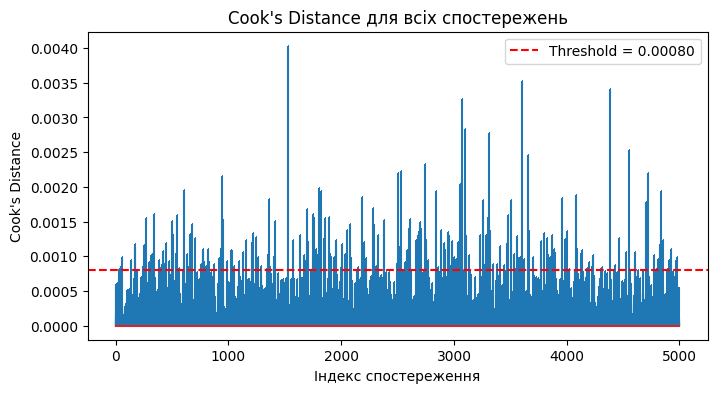

In [96]:
import statsmodels.api as sm


# Додаємо стовпець одиниць (intercept)
X_sm = sm.add_constant(X_train)  # X_train — твої ознаки для навчання

# Створюємо модель OLS через statsmodels
model = sm.OLS(y_train, X_sm).fit()

# Обчислюємо залишки
residuals = y_train - model.predict(X_sm)

# Графік залишків
plt.figure(figsize=(8,5))
plt.scatter(model.predict(X_sm), residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Графік залишків (Residuals)")
plt.xlabel("Передбачені значення")
plt.ylabel("Залишки")
plt.show()

# Cook's distance
influence = model.get_influence()
cooks = influence.cooks_distance[0]

# Поріг впливових точок
n = X_train.shape[0]
threshold = 4 / n

# Впливові точки
influential_points = np.where(cooks > threshold)[0]

print(f"Кількість впливових спостережень: {len(influential_points)}")
print("Індекси впливових спостережень:", influential_points)

# Графік Cook's distance
plt.figure(figsize=(8,4))
plt.stem(np.arange(len(cooks)), cooks, markerfmt=",")
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.5f}')
plt.title("Cook's Distance для всіх спостережень")
plt.xlabel("Індекс спостереження")
plt.ylabel("Cook's Distance")
plt.legend()
plt.show()